In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Flowers-Dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/Flowers-Dataset.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy

Image Augmentation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [5]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/flowers/sunflower'
FLOWER_TULIP_DIR='/content/flowers/tulip'
FLOWER_DANDI_DIR='/content/flowers/dandelion'
FLOWER_ROSE_DIR='/content/flowers/rose'

# New Section

In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:01<00:00, 395.40it/s]

764


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:02<00:00, 337.43it/s]

1497


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:02<00:00, 380.63it/s]

2481


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:02<00:00, 370.00it/s]

3533


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:01<00:00, 414.98it/s]

4317


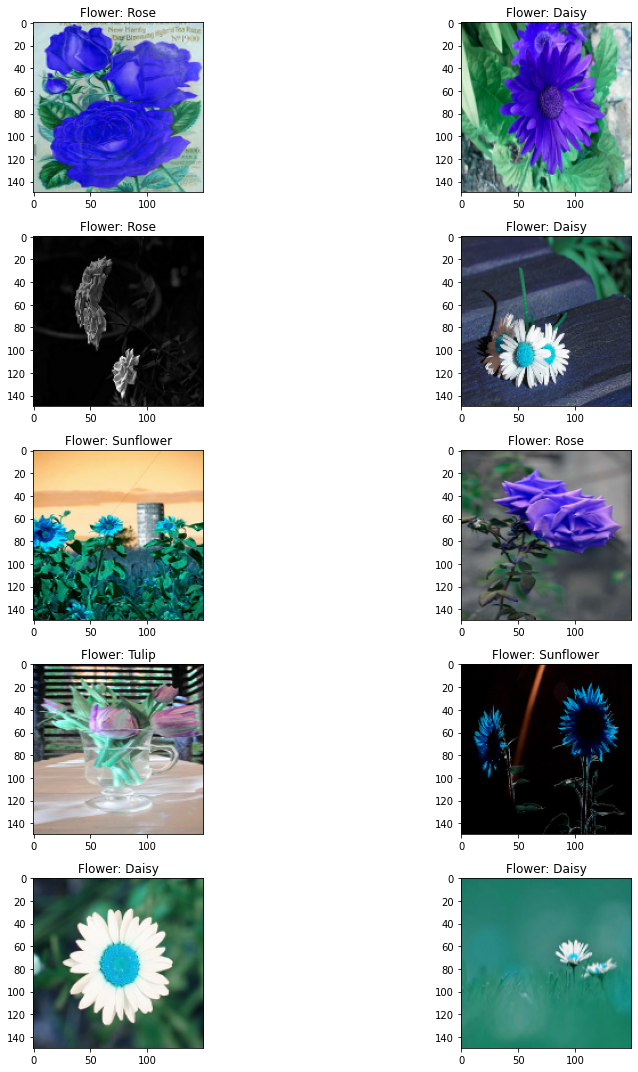

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd 
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

Model Creation and adding layers


In [ ]:
# model using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

Fitting the model

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Compiling the model

In [ ]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

Training the model

In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
25/25 [==============================] - 189s 8s/step - loss: 1.0761 - accuracy: 0.5632 - val_loss: 1.0077 - val_accuracy: 0.5944
Epoch 2/50
25/25 [==============================] - 183s 7s/step - loss: 0.9849 - accuracy: 0.6160 - val_loss: 0.9129 - val_accuracy: 0.6611
Epoch 3/50
25/25 [==============================] - 182s 7s/step - loss: 0.9876 - accuracy: 0.6098 - val_loss: 0.9095 - val_accuracy: 0.6519
Epoch 4/50
25/25 [==============================] - 183s 7s/step - loss: 0.9341 - accuracy: 0.6349 - val_loss: 0.9022 - val_accuracy: 0.6667
Epoch 5/50
25/25 [==============================] - 185s 7s/step - loss: 0.8773 - accuracy: 0.6591 - val_loss: 0.8504 - val_accuracy: 0.6954
Epoch 6/50
25/25 [==============================] - 185s 7s/step - loss: 0.8229 - accuracy: 0.6777 - val_loss: 0.8267 - val_accuracy: 0.6954
Epoch 7/50
25/25 [==============================] - 187s 7s/step - loss: 0.8064 - accuracy: 0.6841 - val_loss: 0.8345 - val_accuracy: 0.6796
Epoch 8/50
25

Saving the model

In [ ]:
model.save('flowers.h5')

Testing the model

In [3]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
#Testing No 1 :-
img = image.load_img('/content/flowers/daisy/102841525_bd6628ae3c.jpg',target_size=(64,64)) #Reading image
f = image.img_to_array(img) #Convertinng image to array
f = np.expand_dims(f,axis=0) #Expanding dimensions
pred = np.argmax(model.predict(f)) #predicting higher propability index
op = ['daisy','dandelion','rose','sunflower','tulip'] #Creating List
op[pred] #List indexing with output

In [ ]:
#Testing No 2 :-
img = image.load_img('/content/flowers/sunflower/1064662314_c5a7891b9f_m.jpg',target_size=(64,64)) #Reading image
f = image.img_to_array(img) #Convertinng image to array
f = np.expand_dims(f,axis=0) #Expanding dimensions
pred = np.argmax(model.predict(f)) #predicting higher propability index
op = ['daisy','dandelion','rose','sunflower','tulip'] #Creating List
op[pred] #List indexing with output